In [0]:
from google.colab import drive
drive.mount('/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
from keras.preprocessing.image import ImageDataGenerator

#Kavi's Dir
train_dir = "/gdrive/My Drive/trainProbMaps/"
val_dir = "/gdrive/My Drive/valProbMaps/"
test_dir = "/gdrive/My Drive/testProbMaps/"

img_width = 600
img_height = 450
batch_size = 1
channels = 3
epochs = 50
nb_train_samples = 408
nb_valid_samples = 149
nb_test_samples = 192

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)             
valid_datagen = ImageDataGenerator(rescale=1./255)    
test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)   

valid_generator = valid_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True) #weight toward one class or another

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

label_mapT = train_generator.class_indices
print(label_mapT)

label_mapV = valid_generator.class_indices
print(label_mapV)

label_mapTe = test_generator.class_indices
print(label_mapTe)

Using TensorFlow backend.


Found 408 images belonging to 2 classes.
Found 149 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
{'controls': 0, 'patients': 1}
{'controls': 0, 'patients': 1}
{'controls': 0, 'patients': 1}


In [0]:
import numpy as np 
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Softmax, Flatten, Dense, BatchNormalization 
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras import regularizers
import tensorflow as tf
from keras.models import Sequential

from PIL import Image

Image.MAX_IMAGE_PIXELS = None

from keras import layers

from keras.callbacks import TensorBoard

#from keras.layers import Input, Dense
from keras import layers
from keras.applications import resnet50
from keras import optimizers
from keras.applications import VGG16

#pretrained VGG16 on imagenet, starting to replicate Hassan's work
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_height, img_width, channels))

conv_base.summary()

#Extracting features from OCT data using pretrained VGG
def extract_features(dataset_type, sample_count):
    features = np.zeros(shape=(sample_count, 14, 18, 512))
    labels = np.zeros(shape=(sample_count))
    i = 0
    if dataset_type == "train":
        for inputs_batch, labels_batch in train_generator:
            features_batch = conv_base.predict(inputs_batch)
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1
            if i * batch_size >= sample_count:
                break   
    elif dataset_type == "valid":
        for inputs_batch, labels_batch in valid_generator:
            features_batch = conv_base.predict(inputs_batch)
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1
            if i * batch_size >= sample_count:
                break
    else:
        for inputs_batch, labels_batch in test_generator:
            features_batch = conv_base.predict(inputs_batch)
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1
            if i * batch_size >= sample_count:
                break
    return features, labels

train_features, train_labels = extract_features("train", nb_train_samples)
valid_features, valid_labels = extract_features("valid", nb_valid_samples)
test_features, test_labels = extract_features("test", nb_test_samples)


print(train_features.shape, train_labels.shape)
print(valid_features.shape, valid_labels.shape)
print(test_features.shape, test_labels.shape)

58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 450, 600, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 450, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 450, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 225, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 225, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 225, 300, 128)     147584    
_________________________________________________________________
block2_pool

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics

clf = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=0, bootstrap=True)
trainResult = clf.fit(np.reshape(train_features, (408, 14*18*512)), train_labels)

valid_prediction = clf.predict(np.reshape(valid_features, (149, 14*18*512)))
print("validation accuracy:", sum([valid_prediction[i] == valid_labels[i] for i in range(len(valid_labels))])/len(valid_labels))
#print(prediction)
#print(valid_labels)

test_prediction = clf.predict(np.reshape(test_features, (192, 14*18*512)))
print("test accuracy:", sum([test_prediction[i] == test_labels[i] for i in range(len(test_labels))])/len(test_labels))
# print(test_prediction)
# print(test_labels)


validation accuracy: 0.9530201342281879
test accuracy: 0.984375


# ROC

In [0]:
import sklearn
from sklearn.metrics import roc_curve, auc

def prepare_ROC_binary(fitter, x_val_f, y_val_f):
  
  n_classes = 2

  proba = fitter.predict_proba(np.reshape(x_val_f, (len(x_val_f), 14*18*512)))

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], thresholds = roc_curve(y_val_f, proba[:, i], pos_label=i)
#       print("fpr, tpr", fpr[i], tpr[i])
      roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
#       print("test AUC for class", i, roc_auc[i])
#       print("thresholds", thresholds)
  
  return fpr, tpr, roc_auc
      

In [0]:
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

def saveROCfigure(fpr, tpr, roc_auc, ith):
  
  n_classes = 2
  
  lw = 2

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#   print(all_fpr)

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
               label='ROC curve of class {0} (area = {1:0.2f})'
               ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.savefig("vgg16_rf_ngd_" + str(ith) + ".png")
  plt.clf()
#   plt.show()

# ROC for NGD

In [0]:
from sklearn.metrics import roc_curve, auc
n_classes = 2
# print(valid_labels)
# print(valid_prediction)

val_score = trainResult.predict_proba(np.reshape(valid_features, (149, 14*18*512)))
test_score = trainResult.predict_proba(np.reshape(test_features, (192, 14*18*512)))
print(val_score[:, ])
# print(test_score)

# Validation
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
#     fpr[i], tpr[i], thresholds = roc_curve(valid_labels, val_score)
#     print(valid_labels.shape)
#     print(val_score.shape)
    fpr[i], tpr[i], thresholds = roc_curve(valid_labels, val_score[:, i], pos_label = i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    print("valid AUC for class", i, roc_auc[i])
    print(thresholds)
    
    
print("\n")
    
# Test
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(test_labels, test_score[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    print("test AUC for class", i, roc_auc[i])
    print("thresholds", thresholds)

[[0.84 0.16]
 [0.94 0.06]
 [0.9  0.1 ]
 [0.94 0.06]
 [0.97 0.03]
 [0.26 0.74]
 [1.   0.  ]
 [0.15 0.85]
 [0.93 0.07]
 [0.86 0.14]
 [0.87 0.13]
 [0.2  0.8 ]
 [0.61 0.39]
 [0.15 0.85]
 [0.89 0.11]
 [0.22 0.78]
 [0.35 0.65]
 [0.4  0.6 ]
 [0.17 0.83]
 [0.96 0.04]
 [0.2  0.8 ]
 [0.97 0.03]
 [0.97 0.03]
 [0.17 0.83]
 [0.04 0.96]
 [0.9  0.1 ]
 [0.46 0.54]
 [0.18 0.82]
 [0.96 0.04]
 [0.43 0.57]
 [0.81 0.19]
 [0.96 0.04]
 [0.15 0.85]
 [0.95 0.05]
 [0.13 0.87]
 [0.97 0.03]
 [0.57 0.43]
 [0.52 0.48]
 [0.11 0.89]
 [0.87 0.13]
 [0.91 0.09]
 [0.25 0.75]
 [0.97 0.03]
 [0.97 0.03]
 [0.98 0.02]
 [0.42 0.58]
 [0.97 0.03]
 [0.94 0.06]
 [0.81 0.19]
 [1.   0.  ]
 [0.99 0.01]
 [0.16 0.84]
 [0.96 0.04]
 [0.09 0.91]
 [0.89 0.11]
 [0.96 0.04]
 [0.97 0.03]
 [0.95 0.05]
 [0.89 0.11]
 [0.39 0.61]
 [0.1  0.9 ]
 [0.48 0.52]
 [0.26 0.74]
 [0.99 0.01]
 [0.95 0.05]
 [0.21 0.79]
 [0.75 0.25]
 [0.77 0.23]
 [0.37 0.63]
 [0.97 0.03]
 [0.99 0.01]
 [0.48 0.52]
 [0.95 0.05]
 [0.8  0.2 ]
 [0.13 0.87]
 [0.42 0.58]
 [0.6  0.4 ]

[0.         0.01       0.01086957 0.02       0.02173913 0.03
 0.05434783 0.07608696 0.09782609 0.1        0.11956522 0.15217391
 0.16       0.17       0.17391304 0.18478261 0.21       0.22
 0.22826087 0.23913043 0.24       0.26086957 0.27       0.30434783
 0.31       0.32       0.32608696 0.33695652 0.36956522 0.37
 0.38043478 0.43       0.45       0.5        0.51086957 0.5326087
 0.56       0.57608696 0.64       0.64130435 0.66       0.73913043
 0.75       0.79347826 0.82       0.85869565 0.9        0.90217391
 0.93       0.93478261 0.97826087 1.        ]


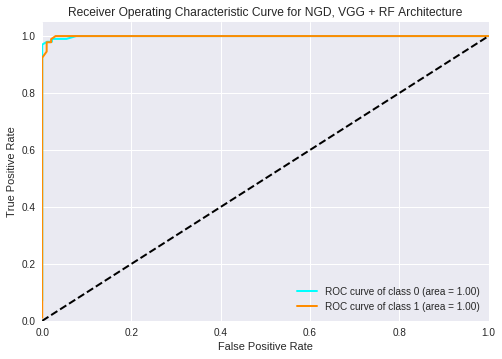

In [0]:
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

lw = 2

# Compute macro-average ROC curve and ROC area

# print(all_fpr)

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

print(all_fpr)

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
# plt.figure()
# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve for NGD, VGG + RF Architecture')
plt.legend(loc="lower right")
plt.savefig("vgg16_rf_ngd.png")
plt.show()